# FX

This notebook illustrates some basic aspects of FX markets, for instance, the definition of currency returns and the idea of UIP. It also implements a carry trade strategy.

## Load Packages and Extra Functions

In [1]:
using Printf, Statistics

include("jlFiles/printmat.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# Currency Returns

There are different ways to quote exchange rates, but this notebook uses $S$ to denote the number of domestic currency units (say, CHFs if you are a Swiss investor) to buy one unit of foreign currency (say, one USD). That is, we treat foreign currency as any other asset.

The next cell calculates the return of the following simple strategy:
- in $t=0$: buy foreign currency (at the price $S_0$) and lend it on foreign money market (at the safe rate $R_f^*$).
- in $t=1$: sell the foreign currency (at the price $S_1$)

Since the strategy is financed by borrowing on the domestic money market (at the rate $R_f$), the excess return is

$
R^e = (1+R_f^*)S_1/S_0 - (1 + R_f)
$

Notice that $R_f$ and $R_f^*$  are the safe rates over the investment period (for instance, one-month period). Conversion from annualized interest rates to these monthly rates is discussed under UIP (below).

### A Remark on the Code
The code uses `Rfˣ` to denote $R_f^*$ (since there is no easy way to get a subscript `f` or a superscript `*`).

In [3]:
S₀  = 1.2        #current spot FX rate, t=0
S₁  = 1.25       #spot FX rate in t=1
Rfˣ = 0.06       #safe ledning rate (foreign) between period 0 and 1
Rf  = 0.04       #safe domestic borrowing rate

Re = (1+Rfˣ)*S₁/S₀ - (1+Rf)

printblue("A simple example of how to calculate the excess return from investing in a foreign currency:\n")
xx = [S₀,Rf,Rfˣ,S₁,Re]
printmat(xx;rowNames=["S₀";"Rf";"Rfˣ";"S₁";"Currency excess return"])

A simple example of how to calculate the excess return from investing in a foreign currency:

S₀                         1.200
Rf                         0.040
Rfˣ                        0.060
S₁                         1.250
Currency excess return     0.064



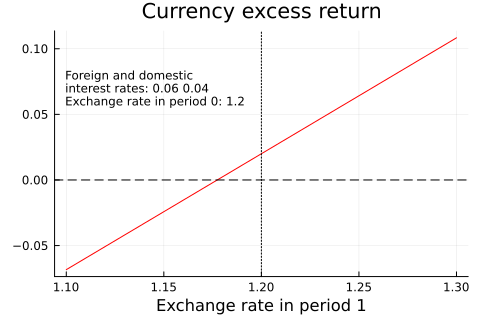

In [4]:
S₁_range = 1.1:0.01:1.3           #range of different possible exchange rates in t=1

Re = (1+Rfˣ)*S₁_range/S₀ .- (1+Rf)  #corresponding returns

txt = "Foreign and domestic \ninterest rates: $Rfˣ $Rf \nExchange rate in period 0: $S₀"

p1 = plot( S₁_range,Re,
           legend = nothing,
           linecolor = :red,
           title = "Currency excess return",
           xlabel = "Exchange rate in period 1",
           annotation = (1.1,0.07,text(txt,8,:left)) )
vline!([S₀],linecolor=:black,line=(:dot,1))
hline!([0],linecolor=:black,line=(:dash,1))
display(p1)

# Uncovered Interest Rate Parity (UIP)


UIP *assumes* that the expected future exchange rate ($\text{E}_0S_m$) is related to the current exchange rate and interest rates in such a way that the expected excess return of a foreign investment is zero.

In addition, interest rates are typically annualized (denoted $Y$ and $Y^*$ below). This means that the safe (gross) rate over an investment period of $m$ years (eg. $m=1/12$ for a month) is $(1+Y)^m$.

In [5]:
S₀  = 1.2                       #current spot FX rate
Y   = 0.04                      #annualized interest rates
Yˣ  = 0.06
m   = 1/2                       #investment period
ESₘ = S₀ * (1+Y)^m/(1+Yˣ)^m     #implies E(excess return) = 0

printblue("Expected future exchange rate $m years ahead according to UIP:\n")
xx = [S₀,Y,Yˣ,m,ESₘ]
printmat(xx;rowNames=["S₀";"Y";"Yˣ";"m";"UIP 'expectation' of Sₘ"])

Expected future exchange rate 0.5 years ahead according to UIP:

S₀                          1.200
Y                           0.040
Yˣ                          0.060
m                           0.500
UIP 'expectation' of Sₘ     1.189



# A Carry Trade Strategy

Means betting on high interest currencies and against low interest rate currencies.

In [6]:
using Dates, DelimitedFiles, Statistics

## Load Data

Returns from FX investments (for a US investor) in percent are in `Data_FxReturns.csv` and log forward premia in percent are in `Data_FxForwardpremia.csv`.

In [7]:
CurrNames = ["AUD","CAD","EUR","JPY","NZD","NOK","SEK","CHF","GBP"]   #currency abbreviations

x  = readdlm("Data/Data_FxReturns.csv",',',skipstart=1)           #return data
(dN,R) = (Date.(x[:,1]),Float64.(x[:,2:end]))

x   = readdlm("Data/Data_FxForwardpremia.csv",',',skipstart=2)    #forward premia, skip 2 rows
(dN2,fp) = (Date.(x[:,1]),Float64.(x[:,2:end]))

(T,n) = size(R)               #number of data points, number of currencies

println("Same dates in the two files? ",dN == dN2)

Same dates in the two files? true


# Sorting on Forward Premia

The `m=3` currencies with the highest forward premia (interest rate differential) in $t-1$  are given portfolio weights `w_CT[t,i] = 1/m`. These are the investment currencies. The `m` currencies with the lowest forward premia in $t-1$ are given portfolio weights `w_CT[t,i] = -1/m`. These are the funding currencies.

### A Remark on the Code
- With `x = [9,7,8]`, the `rankPs(x)` function (see below) gives the output `[3,1,2]`. This says, for instance, that `7` is the lowest number (rank 1).
- `R.*w_CT` creates a `Txn` matrix, `sum(,dims=2)` sums across columns (for each row).

In [8]:
"""
    rankPs(x)

Calculates the ordinal rank of eack element in a vector `x`. As an aternative,
use `ordinalrank` from the `StatsBase.jl` package.

"""
rankPs(x) = invperm(sortperm(x))

rankPs

In [9]:
m = 3                #number of long/short positions

w_CT = zeros(T,n)
for t = 2:T         #loop over periods, save portfolio returns
    #local r,w      #local/global is needed in script
    r                  = rankPs(fp[t-1,:])
    w                  = zeros(n)
    w[r.<=m]          .= -1/m               #low interest rate currencies
    w[(n-m+1).<=r]    .= 1/m                #high interest rate currencies
    w_CT[t,:]          = w
end

R_CT = sum(R.*w_CT,dims=2)              #return on carry trade portfolio

R_EW = mean(R,dims=2);                   #return on equally weighted portfolio

In [14]:
println(size(w_CT)," ",size(R))
R_CT_ = R*w_CT'
#println(R_CT_-R_CT)

(300, 9) (300, 9)


DimensionMismatch: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(300), Base.OneTo(300)), b has dims (Base.OneTo(300), Base.OneTo(1)), mismatch at 2

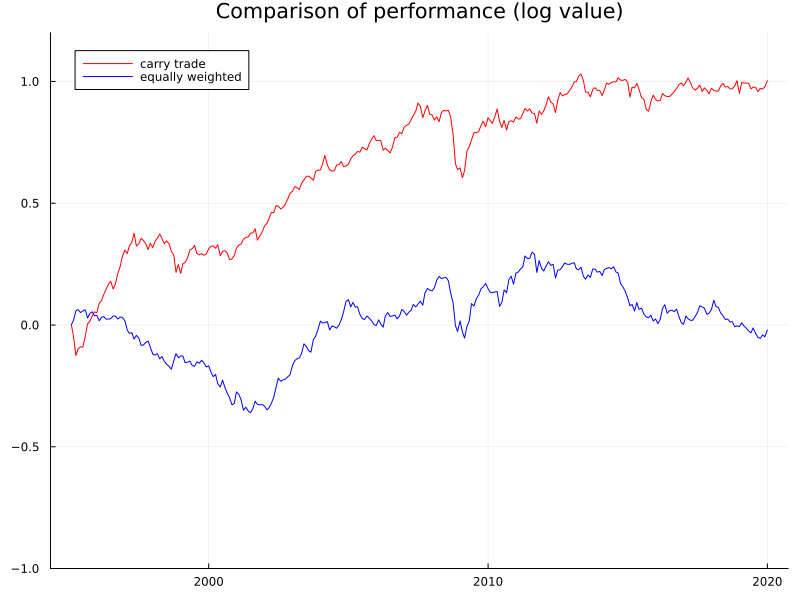

In [10]:
p_CT = cumsum(log.(1.0.+R_CT/100),dims=1)
p_EW = cumsum(log.(1.0.+R_EW/100),dims=1)

xTicksLoc = [Date(2000),Date(2010),Date(2020)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,[p_CT p_EW],
           label = ["carry trade" "equally weighted"],
           size = (800,600),
           linecolor = [:red :blue],
           xticks = (xTicksLoc,xTicksLab),
           ylims = (-1,1.2),
           title = "Comparison of performance (log value)")
display(p1)